In [27]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import seaborn as sns

## Load Data and Preprocessing
The dropped columns are selected via computing the missing rate and picking columns that are with missing rate greater than 75%.

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
dropped_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']
train.drop(dropped_cols, axis=1, inplace=True)
test.drop(dropped_cols, axis=1, inplace=True)

## Prepare Data
The house prices are transformed via logarithm function in order to have the values normal distributed. Then columns with skewness greater than 75% are skewed in order to avoid the overfitting casued by long tail effect.

In [3]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
all_data = pd.get_dummies(all_data)
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Model Measurement

In [8]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "neg_mean_squared_error", cv = 5))
    return rmse

In [9]:
import xgboost as xgb

In [12]:
import multiprocessing

In [13]:
cpu_count = multiprocessing.cpu_count()

In [21]:
params = dict(learning_rate=0.01, n_estimators=5000, silent=False, nthread=cpu_count,reg_alpha=0.9,reg_lambda=0.6,subsample=0.2,)

In [23]:
model = xgb.XGBRegressor(**params)

In [24]:
scores = rmse_cv(model)
scores

array([ 0.10616981,  0.13235252,  0.13101552,  0.109355  ,  0.13208931])

In [26]:
model.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=5000, nthread=4,
       objective='reg:linear', reg_alpha=0.9, reg_lambda=0.6,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.2)

After training gradient boosting model, we are able to know the importance of each features. The number in figure below represents the number of times a feature have been taken into trees. As we can see, "LotArea" is the most important feature in our model.

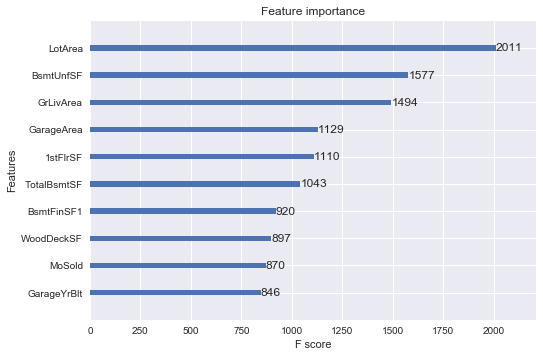

In [29]:
xgb.plot_importance(model, max_num_features=10)